In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import easyocr
import pandas as pd
import cv2
import numpy as np

In [2]:
import easyocr
print(easyocr.__version__)

1.7.2


In [13]:
reader = easyocr.Reader(["en"],gpu=False)

folder_path = 'test_images'

csv_path = 'updated_test_values.csv'
labels_df = pd.read_csv(csv_path)

Using CPU. Note: This module is much faster with a GPU.


In [14]:
ground_truths = dict(zip(labels_df['image_name'], labels_df['label']))

Found 1000 .png files.
Evaluation for a01-000u-01-02.png:
Extracted Text: Lone
Ground Truth: more
Correct: False
Evaluation for a01-003-03-00.png:
Extracted Text: 75
Ground Truth: Foot's
Correct: False
Evaluation for a01-003-06-01.png:
Extracted Text: 7l
Ground Truth: put
Correct: False
Evaluation for a01-003x-04-06.png:
Extracted Text: mk
Ground Truth: into
Correct: False
Evaluation for a01-003x-08-04.png:
Extracted Text: Lp
Ground Truth: up
Correct: False
Evaluation for a01-007-04-04.png:
Extracted Text: Ol
Ground Truth: an
Correct: False
Evaluation for a01-007-08-02.png:
Extracted Text: 
Ground Truth: ,
Correct: False
Evaluation for a01-007u-05-01.png:
Extracted Text: lur_L~Qs)
Ground Truth: members
Correct: False
Evaluation for a01-011-05-04.png:
Extracted Text: buk
Ground Truth: but
Correct: False
Evaluation for a01-011-06-02.png:
Extracted Text: Hachod
Ground Truth: Macleod
Correct: False
Evaluation for a01-011u-09-00.png:
Extracted Text: La
Ground Truth: is
Correct: False
Evalua

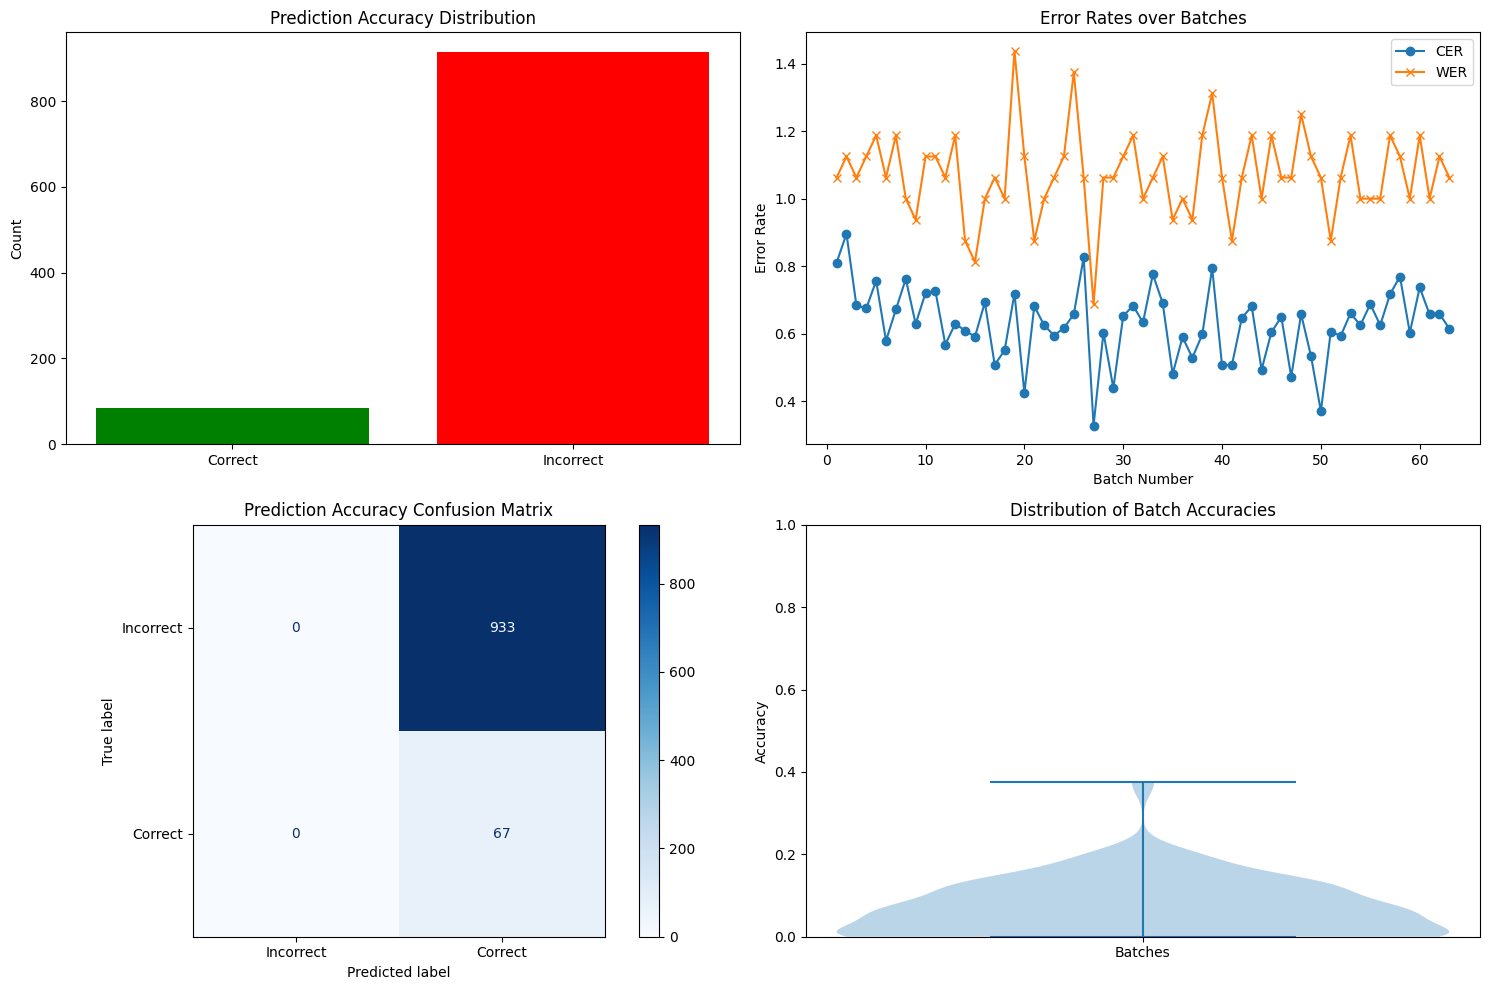


Test Results:
Total images processed: 1000
Correct predictions: 85
Accuracy: 8.50%
Character Error Rate (CER): 0.6245
Word Error Rate (WER): 1.0700


In [15]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from jiwer import cer, wer  # For CER and WER calculations

# Initialize variables for evaluation
correct = 0
total = 0
batch_numbers = []
batch_cer = []
batch_wer = []
pred_texts_all = []
true_labels_all = []

import os

# Define the folder path where your images are stored
folder_path = "test_images"  # Replace with the actual path to your folder

# List all .png files in the folder
files = [filename for filename in os.listdir(folder_path) if filename.endswith('.png') and os.path.isfile(os.path.join(folder_path, filename))]

# Check if files are found
if not files:
    print("No .png files found in the specified folder.")
else:
    print(f"Found {len(files)} .png files.")

# Preprocessing and resize function
def preprocess_and_resize_image(image_path, target_size):
    """
    Preprocess an image and resize without distortion.
    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Desired output image size (width, height).
    Returns:
        np.array: Preprocessed and resized image.
    """
    img = cv2.imread(image_path)
    original_height, original_width = img.shape[:2]
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    enhancer = ImageEnhance.Contrast(Image.fromarray(gray_img))
    enhanced_img = np.array(enhancer.enhance(6))
    _, threshold_img = cv2.threshold(enhanced_img, 175, 255, cv2.THRESH_BINARY)

    target_width, target_height = target_size
    scale = min(target_width / original_width, target_height / original_height)
    resized_width = int(original_width * scale)
    resized_height = int(original_height * scale)

    resized_img = cv2.resize(threshold_img, (resized_width, resized_height), interpolation=cv2.INTER_AREA)
    pad_top = (target_height - resized_height) // 2
    pad_bottom = target_height - resized_height - pad_top
    pad_left = (target_width - resized_width) // 2
    pad_right = target_width - resized_width - pad_left

    padded_img = cv2.copyMakeBorder(resized_img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=255)
    return padded_img

# OCR and evaluation process
for idx, file in enumerate(files):
    image_path = os.path.join(folder_path, file)
    preprocessed_image = preprocess_and_resize_image(image_path, target_size=(224, 224))
    result = reader.readtext(preprocessed_image)
    extracted_text = " ".join([text[1] for text in result]) if result else ""
    ground_truth = ground_truths.get(file, "")

    # Store predictions and ground truths for later analysis
    pred_texts_all.append(extracted_text)
    true_labels_all.append(ground_truth)

    # Evaluate correctness
    is_correct = extracted_text.strip().lower() == ground_truth.strip().lower()
    total += 1
    if is_correct:
        correct += 1

    # Batch-level CER and WER calculation
    if (idx + 1) % 16 == 0 or idx == len(files) - 1:  # Process in batches of 16
        batch_pred = pred_texts_all[-16:]
        batch_true = true_labels_all[-16:]
        batch_cer.append(cer(batch_true, batch_pred))
        batch_wer.append(wer(batch_true, batch_pred))
        batch_numbers.append(len(batch_numbers) + 1)

    # Print evaluation for each file
    print(f"Evaluation for {file}:")
    print(f"Extracted Text: {extracted_text}")
    print(f"Ground Truth: {ground_truth}")
    print(f"Correct: {is_correct}")
    print("====================================")

# Overall accuracy
accuracy = correct / total if total > 0 else 0
print(f"Overall Accuracy: {accuracy:.4f}")

# Plot results
def plot_results(true_match, total_processed, batch_numbers, batch_cer, batch_wer,
                pred_texts_all, true_labels_all):
    """Plot test results including violin plot"""
    # Create a figure with subplots
    plt.figure(figsize=(15, 10))

    # Original plots in a 2x2 grid
    plt.subplot(2, 2, 1)
    # Accuracy Distribution
    correct_preds = true_match
    incorrect_preds = total_processed - true_match
    plt.bar(['Correct', 'Incorrect'], [correct_preds, incorrect_preds], color=['green', 'red'])
    plt.title("Prediction Accuracy Distribution")
    plt.ylabel("Count")

    # Error Rates Over Batches
    plt.subplot(2, 2, 2)
    plt.plot(batch_numbers, batch_cer, label="CER", marker='o')
    plt.plot(batch_numbers, batch_wer, label="WER", marker='x')
    plt.title("Error Rates over Batches")
    plt.xlabel("Batch Number")
    plt.ylabel("Error Rate")
    plt.legend()

    # Confusion Matrix
    plt.subplot(2, 2, 3)
    y_true = [1 if pred.strip() == true.strip() else 0
              for pred, true in zip(pred_texts_all, true_labels_all)]
    y_pred = [1] * len(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Incorrect", "Correct"])
    disp.plot(ax=plt.gca(), cmap=plt.cm.Blues)
    plt.title("Prediction Accuracy Confusion Matrix")

    # Add Violin Plot
    plt.subplot(2, 2, 4)
    # Calculate accuracy per batch
    batch_size = 16
    batch_accuracies = []
    for i in range(0, len(pred_texts_all), batch_size):
        batch_pred = pred_texts_all[i:i+batch_size]
        batch_true = true_labels_all[i:i+batch_size]
        batch_acc = sum(1 for p, t in zip(batch_pred, batch_true)
                       if p.strip() == str(t).strip()) / len(batch_pred)
        batch_accuracies.append(batch_acc)

    # Create violin plot
    plt.violinplot(batch_accuracies, positions=[1])
    plt.title("Distribution of Batch Accuracies")
    plt.ylabel("Accuracy")
    plt.xticks([1], ['Batches'])
    plt.ylim(0, 1)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Print Statistics
    print("\nTest Results:")
    print(f"Total images processed: {total_processed}")
    print(f"Correct predictions: {true_match}")
    print(f"Accuracy: {(true_match/total_processed)*100:.2f}%")
    print(f"Character Error Rate (CER): {cer(true_labels_all, pred_texts_all):.4f}")
    print(f"Word Error Rate (WER): {wer(true_labels_all, pred_texts_all):.4f}")

# Call the plot_results function
plot_results(correct, total, batch_numbers, batch_cer, batch_wer, pred_texts_all, true_labels_all)